<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 388, '日付': '2021-06-19T08:00:00.000Z'},
 {'小計': 376, '日付': '2021-06-20T08:00:00.000Z'},
 {'小計': 236, '日付': '2021-06-21T08:00:00.000Z'},
 {'小計': 435, '日付': '2021-06-22T08:00:00.000Z'},
 {'小計': 619, '日付': '2021-06-23T08:00:00.000Z'},
 {'小計': 570, '日付': '2021-06-24T08:00:00.000Z'},
 {'小計': 562, '日付': '2021-06-25T08:00:00.000Z'},
 {'小計': 534, '日付': '2021-06-26T08:00:00.000Z'},
 {'小計': 386, '日付': '2021-06-27T08:00:00.000Z'},
 {'小計': 317, '日付': '2021-06-28T08:00:00.000Z'},
 {'小計': 476, '日付': '2021-06-29T08:00:00.000Z'},
 {'小計': 714, '日付': '2021-06-30T08:00:00.000Z'},
 {'小計': 673, '日付': '2021-07-01T08:00:00.000Z'},
 {'小計': 660, '日付': '2021-07-02T08:00:00.000Z'},
 {'小計': 716, '日付': '2021-07-03T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-06-29 17:00:00+09:00,352,0,476,2021-06-29 17:00:00+09:00
2021-06-30 17:00:00+09:00,412,0,714,2021-06-30 17:00:00+09:00
2021-07-01 17:00:00+09:00,444,0,673,2021-07-01 17:00:00+09:00
2021-07-02 17:00:00+09:00,0,0,660,2021-07-02 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-06-29 17:00:00+09:00,352,0,476,2021-06-29 17:00:00+09:00,360.428571,2523.0,0.0,0.0,494.857143,3464.0
2021-06-30 17:00:00+09:00,412,0,714,2021-06-30 17:00:00+09:00,365.714286,2560.0,0.0,0.0,508.428571,3559.0
2021-07-01 17:00:00+09:00,444,0,673,2021-07-01 17:00:00+09:00,380.000000,2660.0,0.0,0.0,523.142857,3662.0
2021-07-02 17:00:00+09:00,0,0,660,2021-07-02 17:00:00+09:00,329.142857,2304.0,0.0,0.0,537.142857,3760.0
2021-07-03 17:00:00+09:00,0,0,716,2021-07-03 17:00:00+09:00,279.857143,1959.0,0.0,0.0,563.142857,3942.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-06-19 17:00:00+09:00,347,0,388,2021-06-19 17:00:00+09:00,330.000000,2310.0,0.0,0.0,377.714286,2644.0,'21w24,Sat
2021-06-20 17:00:00+09:00,334,0,376,2021-06-20 17:00:00+09:00,337.285714,2361.0,0.0,0.0,388.000000,2716.0,'21w24,Sun
2021-06-21 17:00:00+09:00,373,0,236,2021-06-21 17:00:00+09:00,340.000000,2380.0,0.0,0.0,391.857143,2743.0,'21w25,Mon
2021-06-22 17:00:00+09:00,330,0,435,2021-06-22 17:00:00+09:00,339.000000,2373.0,0.0,0.0,405.857143,2841.0,'21w25,Tue
2021-06-23 17:00:00+09:00,375,0,619,2021-06-23 17:00:00+09:00,347.000000,2429.0,0.0,0.0,422.714286,2959.0,'21w25,Wed
2021-06-24 17:00:00+09:00,344,0,570,2021-06-24 17:00:00+09:00,345.285714,2417.0,0.0,0.0,439.571429,3077.0,'21w25,Thu
2021-06-25 17:00:00+09:00,356,0,562,2021-06-25 17:00:00+09:00,351.285714,2459.0,0.0,0.0,455.142857,3186.0,'21w25,Fri
2021-06-26 17:00:00+09:00,345,0,534,2021-06-26 17:00:00+09:00,351.000000,2457.0,0.0,0.0,476.000000,3332.0,'21w25,Sat
2021-06-27 17:00:00+09:00,360,0,386,2021-06-27 17:00:00+09:00,354.714286,2483.0,0.0,0.0,477.428571,3342.0,'21w25,Sun
2021-06-28 17:00:00+09:00,391,0,317,2021-06-28 17:00:00+09:00,357.285714,2501.0,0.0,0.0,489.000000,3423.0,'21w26,Mon


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-06-13 17:00:00+09:00,384.142857,2689
2021-06-20 17:00:00+09:00,388.000000,2716
2021-06-27 17:00:00+09:00,477.428571,3342
2021-07-03 17:00:00+09:00,592.666667,3556
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-06-19 17:00:00+09:00,347,0,388,2021-06-19 17:00:00+09:00,330.000000,2310.0,0.0,0.0,377.714286,2644.0,'21w24,Sat,NaN,NaN
2021-06-20 17:00:00+09:00,334,0,376,2021-06-20 17:00:00+09:00,337.285714,2361.0,0.0,0.0,388.000000,2716.0,'21w24,Sun,388.000000,2716.0
2021-06-21 17:00:00+09:00,373,0,236,2021-06-21 17:00:00+09:00,340.000000,2380.0,0.0,0.0,391.857143,2743.0,'21w25,Mon,NaN,NaN
2021-06-22 17:00:00+09:00,330,0,435,2021-06-22 17:00:00+09:00,339.000000,2373.0,0.0,0.0,405.857143,2841.0,'21w25,Tue,NaN,NaN
2021-06-23 17:00:00+09:00,375,0,619,2021-06-23 17:00:00+09:00,347.000000,2429.0,0.0,0.0,422.714286,2959.0,'21w25,Wed,NaN,NaN
2021-06-24 17:00:00+09:00,344,0,570,2021-06-24 17:00:00+09:00,345.285714,2417.0,0.0,0.0,439.571429,3077.0,'21w25,Thu,NaN,NaN
2021-06-25 17:00:00+09:00,356,0,562,2021-06-25 17:00:00+09:00,351.285714,2459.0,0.0,0.0,455.142857,3186.0,'21w25,Fri,NaN,NaN
2021-06-26 17:00:00+09:00,345,0,534,2021-06-26 17:00:00+09:00,351.000000,2457.0,0.0,0.0,476.000000,3332.0,'21w25,Sat,NaN,NaN
2021-06-27 17:00:00+09:00,360,0,386,2021-06-27 17:00:00+09:00,354.714286,2483.0,0.0,0.0,477.428571,3342.0,'21w25,Sun,477.428571,3342.0
2021-06-28 17:00:00+09:00,391,0,317,2021-06-28 17:00:00+09:00,357.285714,2501.0,0.0,0.0,489.000000,3423.0,'21w26,Mon,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

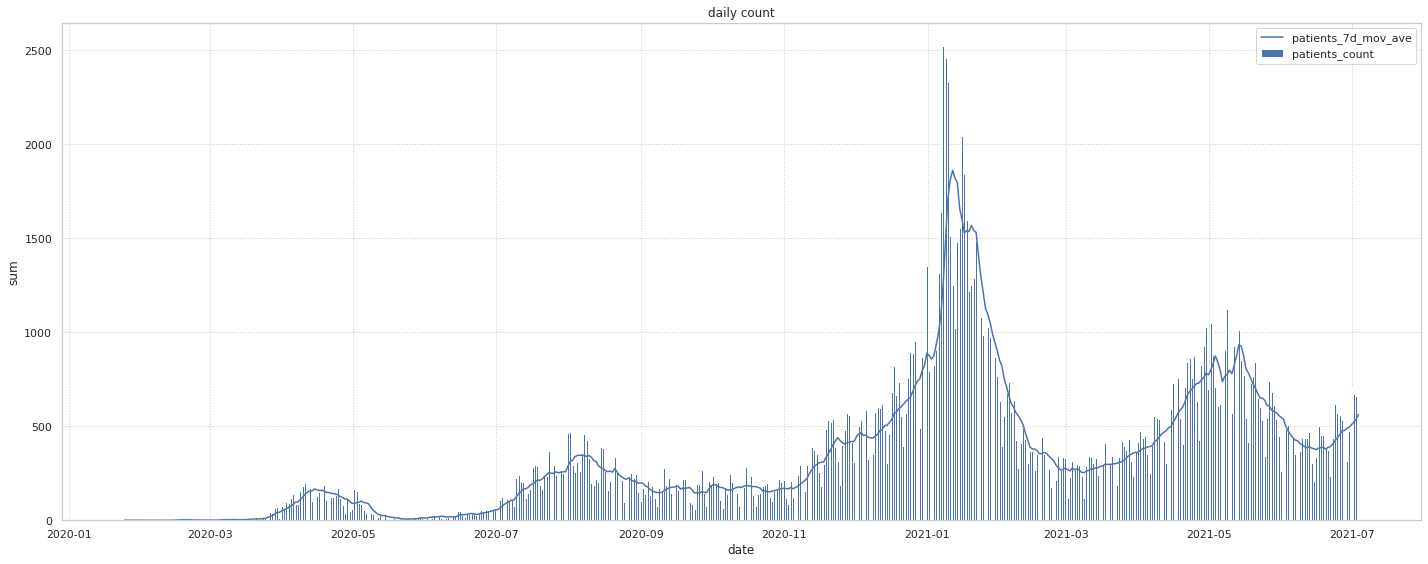

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
512,1.624090e+09,2021,6,19,0,0,1,0,0,0,0,512,0,438,347,330.000000,2310.0,0,0.0,0.0,388,377.714286,2644.0
513,1.624176e+09,2021,6,20,0,0,0,1,0,0,0,513,0,439,334,337.285714,2361.0,0,0.0,0.0,376,388.000000,2716.0
514,1.624262e+09,2021,6,21,0,1,0,0,0,0,0,514,0,440,373,340.000000,2380.0,0,0.0,0.0,236,391.857143,2743.0
515,1.624349e+09,2021,6,22,0,0,0,0,0,1,0,515,0,441,330,339.000000,2373.0,0,0.0,0.0,435,405.857143,2841.0
516,1.624435e+09,2021,6,23,0,0,0,0,0,0,1,516,0,442,375,347.000000,2429.0,0,0.0,0.0,619,422.714286,2959.0
517,1.624522e+09,2021,6,24,0,0,0,0,1,0,0,517,0,443,344,345.285714,2417.0,0,0.0,0.0,570,439.571429,3077.0
518,1.624608e+09,2021,6,25,1,0,0,0,0,0,0,518,0,444,356,351.285714,2459.0,0,0.0,0.0,562,455.142857,3186.0
519,1.624694e+09,2021,6,26,0,0,1,0,0,0,0,519,0,445,345,351.000000,2457.0,0,0.0,0.0,534,476.000000,3332.0
520,1.624781e+09,2021,6,27,0,0,0,1,0,0,0,520,0,446,360,354.714286,2483.0,0,0.0,0.0,386,477.428571,3342.0
521,1.624867e+09,2021,6,28,0,1,0,0,0,0,0,521,0,447,391,357.285714,2501.0,0,0.0,0.0,317,489.000000,3423.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            527 non-null    float64
 1   year                 527 non-null    int64  
 2   month                527 non-null    int64  
 3   day                  527 non-null    int64  
 4   Fri                  527 non-null    uint8  
 5   Mon                  527 non-null    uint8  
 6   Sat                  527 non-null    uint8  
 7   Sun                  527 non-null    uint8  
 8   Thu                  527 non-null    uint8  
 9   Tue                  527 non-null    uint8  
 10  Wed                  527 non-null    uint8  
 11  passed               527 non-null    int64  
 12  emergency            527 non-null    int64  
 13  em_passed            527 non-null    int64  
 14  contacts_count       527 non-null    int64  
 15  contacts_7d_mov_ave  527 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,5.270000e+02,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000,527.000000
mean,1.602576e+09,2020.349146,5.724858,15.789374,0.144213,0.142315,0.144213,0.142315,0.142315,0.142315,0.142315,263.000000,0.092979,194.265655,651.451613,650.339342,4552.368121,699.277040,699.277040,4894.939279,333.933586,330.224532,2311.540797
std,1.315665e+07,0.477153,3.232765,8.878737,0.351639,0.349705,0.351639,0.349705,0.349705,0.349705,0.349705,152.276065,0.290679,144.582136,431.893339,419.062408,2933.448100,863.152886,777.335700,5441.349898,364.506945,343.455844,2404.220654
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.591214e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,131.500000,0.000000,57.500000,368.000000,368.142857,2577.000000,0.000000,0.000000,0.000000,75.500000,88.714286,621.000000
50%,1.602576e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,189.000000,517.000000,528.571429,3700.000000,35.000000,144.857143,1014.000000,236.000000,250.285714,1752.000000
75%,1.613938e+09,2021.000000,8.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.500000,0.000000,320.500000,761.500000,743.214286,5202.500000,1333.500000,1328.285714,9298.000000,461.500000,452.214286,3165.500000
max,1.625299e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,526.000000,1.000000,452.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.825670,0.084847,0.006395,-0.001349,-0.002678,0.001349,-0.005355,0.005355,4.233114e-18,0.002678,1.000000e+00,-0.347255,0.996025,-0.327009,-0.310974,-0.310969,-0.553315,-0.596644,-0.596644,0.608860,0.646442,0.646456
year,8.256705e-01,1.000000,-0.489758,-0.033766,0.005268,-0.002119,0.005268,-0.002119,-0.002119,-2.118704e-03,-0.002119,8.256705e-01,-0.234502,0.842908,-0.309897,-0.288601,-0.288598,-0.593931,-0.659500,-0.659500,0.592745,0.647836,0.647838
month,8.484740e-02,-0.489758,1.000000,-0.020436,-0.011856,-0.000613,-0.006839,-0.005658,0.012841,4.432310e-03,0.007796,8.484740e-02,-0.120413,0.047970,0.045002,0.032302,0.032306,0.196191,0.246591,0.246591,-0.108139,-0.148915,-0.148894
day,6.395166e-03,-0.033766,-0.020436,1.000000,0.004876,0.002937,-0.004867,0.012122,-0.008696,-7.471869e-03,0.001100,6.395166e-03,-0.003447,0.007817,-0.013677,-0.016297,-0.016301,0.003998,-0.010459,-0.010459,-0.007558,0.005322,0.005309
Fri,-1.349178e-03,0.005268,-0.011856,0.004876,1.000000,-0.167217,-0.168514,-0.167217,-0.167217,-1.672168e-01,-0.167217,-1.349178e-03,-0.001235,-0.000344,-0.022299,-0.004913,-0.004912,0.031049,-0.003474,-0.003474,0.049170,-0.000914,-0.000922
Mon,-2.677578e-03,-0.002119,-0.000613,0.002937,-0.167217,1.000000,-0.167217,-0.165929,-0.165929,-1.659292e-01,-0.165929,-2.677578e-03,0.000497,-0.002780,0.042132,0.001258,0.001259,0.137141,0.001397,0.001397,-0.138063,-0.001407,-0.001405
Sat,1.349178e-03,0.005268,-0.006839,-0.004867,-0.168514,-0.167217,1.000000,-0.167217,-0.167217,-1.672168e-01,-0.167217,1.349178e-03,-0.001235,0.002087,0.039003,-0.004913,-0.004912,-0.159117,-0.003474,-0.003474,0.063009,0.000694,0.000688
Sun,-5.355157e-03,-0.002119,-0.005658,0.012122,-0.167217,-0.165929,-0.167217,1.000000,-0.165929,-1.659292e-01,-0.165929,-5.355157e-03,0.000497,-0.005186,-0.020717,0.000533,0.000534,-0.143254,0.001397,0.001397,-0.042506,-0.002122,-0.002122
Thu,5.355157e-03,-0.002119,0.012841,-0.008696,-0.167217,-0.165929,-0.167217,-0.165929,1.000000,-1.659292e-01,-0.165929,5.355157e-03,0.000497,0.004515,-0.004026,0.003497,0.003498,0.040903,0.001397,0.001397,0.083237,0.002802,0.002807
Tue,4.233114e-18,-0.002119,0.004432,-0.007472,-0.167217,-0.165929,-0.167217,-0.165929,-0.165929,1.000000e+00,-0.165929,-2.536712e-19,0.000497,-0.000373,-0.022731,0.001910,0.001911,0.055471,0.001397,0.001397,-0.035750,-0.000333,-0.000329


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,1.624954e+09,0,0,0,0,0,1,0,522,0,448,352,0,476,494.857143,3464.0
523,1.625040e+09,0,0,0,0,0,0,1,523,0,449,412,0,714,508.428571,3559.0
524,1.625126e+09,0,0,0,0,1,0,0,524,0,450,444,0,673,523.142857,3662.0
525,1.625213e+09,1,0,0,0,0,0,0,525,0,451,0,0,660,537.142857,3760.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
522,1.624954e+09,522,0,476,494.857143,3464.0
523,1.625040e+09,523,0,714,508.428571,3559.0
524,1.625126e+09,524,0,673,523.142857,3662.0
525,1.625213e+09,525,0,660,537.142857,3760.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

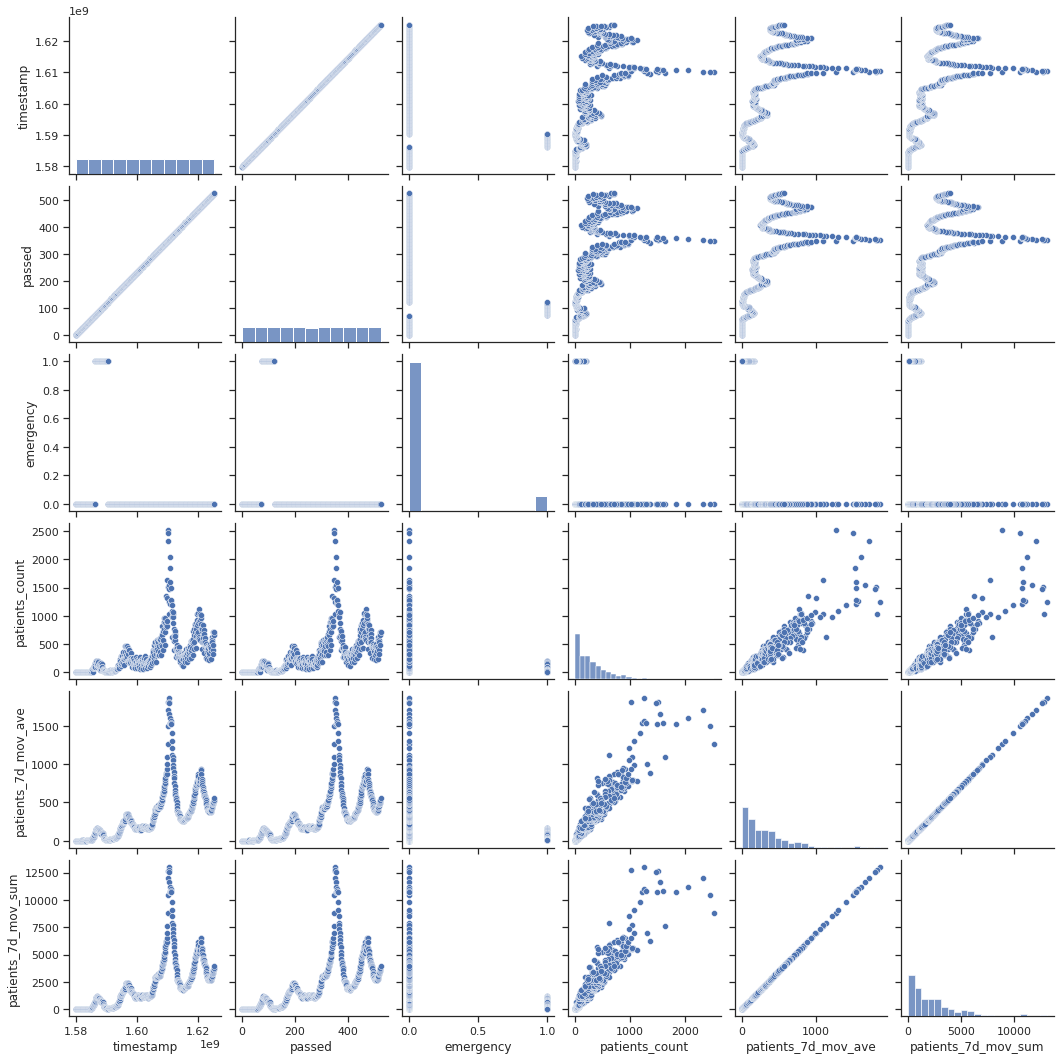

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
